In [11]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

# linear Koopman
from core.koopman_core_linear import KoopDNN as KoopDNN_lin
from core.koopman_core_linear import KoopmanNet as KoopmanNet_lin
from core.koopman_core_linear import KoopmanNetCtrl as KoopmanNetCtrl_lin
from core.adapt_net_lin import AdaptNet_lin


# Bilinear Koopman
from core.koopman_core import KoopDNN as KoopDNN_bil
from core.koopman_core import KoopmanNet as KoopmanNet_bil
from core.koopman_core import KoopmanNetCtrl as KoopmanNetCtrl_bil
from core.adapt_net import AdaptNet


from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff_data_gen, dynamics_duff
from dynamics.Vanpol import dynamics_vanpol

## utilities
from core.utility import Output_Con
import control as ct

In [12]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 500 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [13]:
# Oscillator parameters
dyn_pars = {}

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5

dyn_pars['del_a'] = 0.2
dyn_pars['del_b'] = 0.3
dyn_pars['del_c'] = 0.4
dyn_pars['del_d'] = 0.3
dyn_pars['delay'] = False
dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'sinusoidal'

In [14]:
X_changed, X_unchanged, U = dynamics_duff_data_gen(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_changed.shape, U.shape)

(250, 501, 2) (250, 500, 1)


In [15]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [16]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  0.11862873549473427


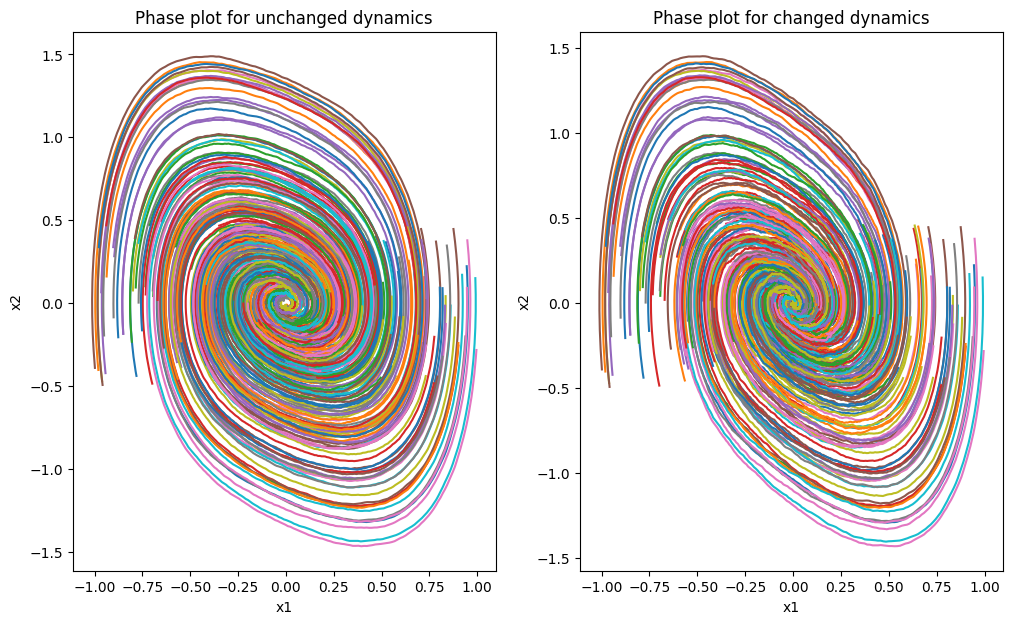

In [17]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])

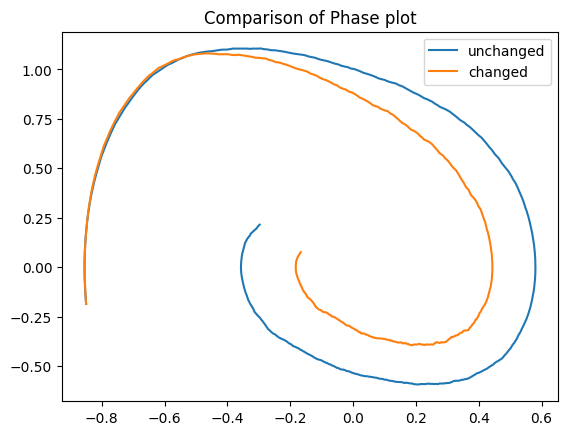

In [18]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.savefig('phase_plot_duffing_single_traj.jpg')
plt.show()

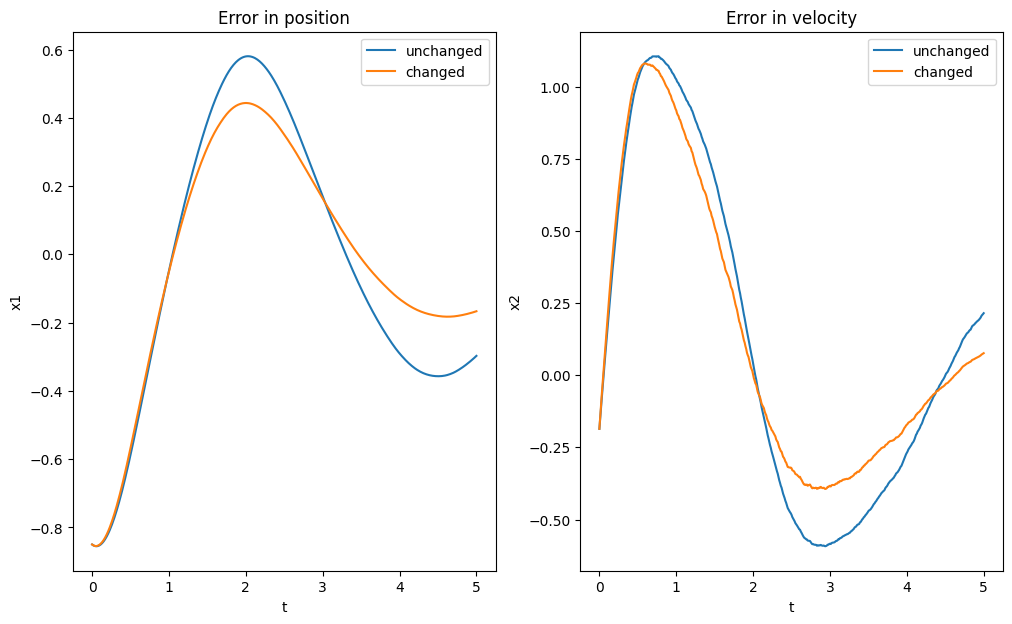

In [19]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

In [20]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

In [21]:
# auto encoder parameters for linear

net_params_lin = {}
net_params_lin['state_dim'] = num_states
net_params_lin['ctrl_dim'] = num_inputs
net_params_lin['encoder_hidden_width'] = 30
net_params_lin['encoder_hidden_depth'] = 2
net_params_lin['encoder_output_dim'] = 20
net_params_lin['optimizer'] = 'adam'
net_params_lin['activation_type'] = 'tanh'
net_params_lin['lr'] = 2e-4 # 5e-4
net_params_lin['epochs'] = 300
net_params_lin['batch_size'] = 256
net_params_lin['lifted_loss_penalty'] = 0.3
net_params_lin['l2_reg'] = 0.0         
net_params_lin['l1_reg'] = 0.0
net_params_lin['first_obs_const'] = True
net_params_lin['override_C'] = True # this makes the state a part of lifted state
net_params_lin['dt'] = dt

# auto encoder parameters for bilinear
net_params_bil = {}
net_params_bil['state_dim'] = num_states
net_params_bil['ctrl_dim'] = num_inputs
net_params_bil['encoder_hidden_width'] = 30
net_params_bil['encoder_hidden_depth'] = 2
net_params_bil['encoder_output_dim'] = 20
net_params_bil['optimizer'] = 'adam'
net_params_bil['activation_type'] = 'tanh'
net_params_bil['lr'] = 2e-4 # 5e-4
net_params_bil['epochs'] = 300
net_params_bil['batch_size'] = 256
net_params_bil['lifted_loss_penalty'] = 0.3
net_params_bil['l2_reg'] = 0.0         
net_params_bil['l1_reg'] = 0.0
net_params_bil['first_obs_const'] = True
net_params_bil['override_C'] = True # this makes the state a part of lifted state
net_params_bil['dt'] = dt

In [22]:
## linear model Training
train = False

if train == True:
    file = 'saved_models/duff_linear_cont.pth'
    net_lin = KoopmanNetCtrl_lin(net_params_lin)
    model_koop_dnn_lin = KoopDNN_lin(net_lin)
    model_koop_dnn_lin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn_lin.model_pipeline(net_params_lin)
    model_koop_dnn_lin.construct_koopman_model()
    torch.save(model_koop_dnn_lin,file)
else:
    file = 'saved_models/duff_linear_cont.pth'
    model_koop_dnn_lin = torch.load(file)

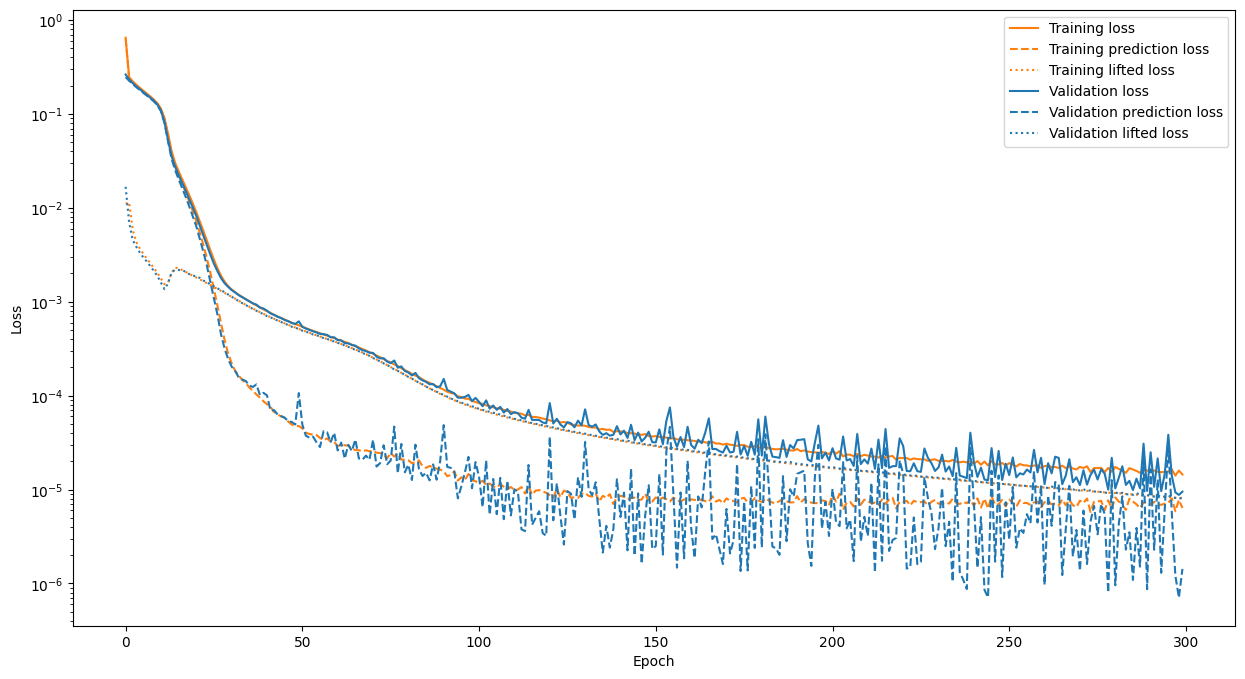

In [23]:
train_loss = [l[0] for l in model_koop_dnn_lin.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn_lin.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn_lin.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn_lin.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn_lin.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn_lin.val_loss_hist]
epochs = np.arange(0, net_params_lin['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [24]:
## linear model Training
train = False

if train == True:
    file = 'saved_models/duff_bilinear_cont.pth'
    net_bil = KoopmanNetCtrl_bil(net_params_bil)
    model_koop_dnn_bil = KoopDNN_lin(net_bil)
    model_koop_dnn_bil.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn_bil.model_pipeline(net_params_lin)
    model_koop_dnn_bil.construct_koopman_model()
    torch.save(model_koop_dnn_bil,file)
else:
    file = 'saved_models/duff_bilinear_cont.pth'
    model_koop_dnn_bil = torch.load(file)

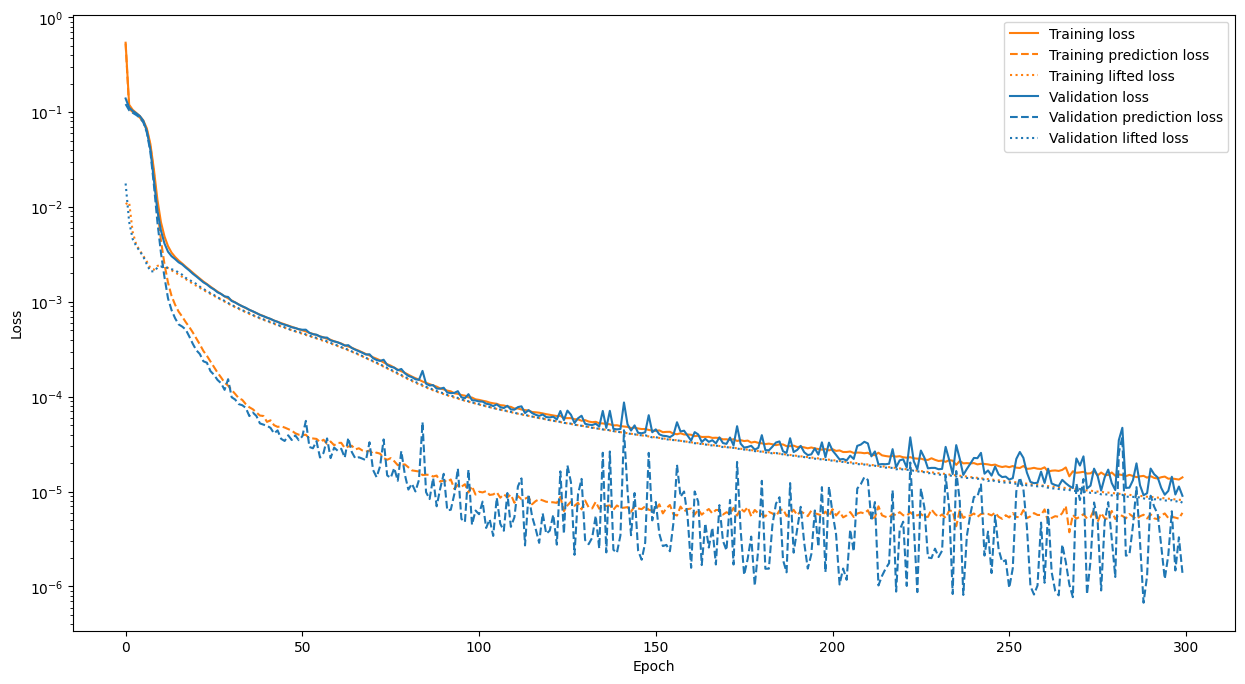

In [25]:
train_loss = [l[0] for l in model_koop_dnn_bil.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn_bil.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn_bil.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn_bil.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn_bil.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn_bil.val_loss_hist]
epochs = np.arange(0, net_params_bil['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Learned Model Parameters

## linear Model Parameters

In [26]:
A_lin = np.array(model_koop_dnn_lin.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B_lin = np.array(model_koop_dnn_lin.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C_lin = np.array(model_koop_dnn_lin.C)

print(A_lin.shape, B_lin.shape, C_lin.shape)

(23, 23) (23, 1) (2, 23)


## bilinear Model Parameters

In [27]:
A_bil = np.array(model_koop_dnn_bil.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B_bil = np.array(model_koop_dnn_bil.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C_bil = np.array(model_koop_dnn_bil.C)

print(A_bil.shape, B_bil.shape, C_bil.shape)

(23, 23) (23, 23) (2, 23)


## Controllabilty

In [28]:
# define no of observables
first_obs_const = int(net_params_lin['first_obs_const']) #only one state
override_C = net_params_lin['override_C']
if override_C:
    n_obs = int(net_params_lin['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params_lin['encoder_output_dim']) + first_obs_const 

## convert matricies to controllable forms
Ac_lin = (A_lin-np.eye(n_obs))/dt
Bc_lin = B_lin/dt
Cc_lin = C_lin

## convert matricies to controllable forms
Ac_bil = (A_bil-np.eye(n_obs))/dt
Bc_bil = B_bil/dt
Cc_bil = C_bil


In [29]:
#check controllability
Con_lin = ct.ctrb(Ac_lin, Bc_lin)
rank_lin = np.linalg.matrix_rank(Con_lin)


Con_bil = ct.ctrb(Ac_bil, Bc_bil)
rank_bil = np.linalg.matrix_rank(Con_bil)

print("Controllability for linear Koopman :", rank_lin)
print("Controllability for bilinear Koopman :", rank_bil)

Controllability for linear Koopman : 7
Controllability for bilinear Koopman : 4


## Output Contrability

In [30]:
out_con_mat, out_con_rank = Output_Con(A_lin,B_lin,C_lin)


print(out_con_mat.shape)
print(out_con_rank)

(2, 24)
2


## Testing

In [31]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples


In [32]:
first_obs_const = int(net_params_lin['first_obs_const']) #only one state
override_C = net_params_lin['override_C']
if override_C:
    n_obs = int(net_params_lin['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params_lin['encoder_output_dim']) + first_obs_const  

In [33]:
x_changed_test, x_unchanged_test, u_test = dynamics_duff_data_gen(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
print(model_koop_dnn_lin.test_loss(x_unchanged_test,u_test = u_test))

tensor(6.0261e-07)


In [34]:
X_unchanged,_ = model_koop_dnn_lin.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn_lin.net.process(x_changed_test,data_u = u_test)

In [35]:
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(2000, 2) (2000, 1) (2000, 2)


In [36]:
z_unchanged_lin = np.empty((n_obs,num_snaps_test+1)).T
z_unchanged_bil = np.empty((n_obs,num_snaps_test+1)).T#lifted state

x_unchanged_lin_est = np.zeros((num_states,num_snaps_test+1)).T 
x_unchanged_bil_est = np.zeros((num_states,num_snaps_test+1)).T 

z_unchanged_lin[0,:] = lift(x_unchanged[0,:],model_koop_dnn_lin, net_params_lin)
z_unchanged_bil[0,:] = lift(x_unchanged[0,:],model_koop_dnn_bil, net_params_bil)
x_unchanged_bil_est[0,:] = x_unchanged[0,:]
x_unchanged_lin_est[0,:] = x_unchanged[0,:]

In [37]:
for i in range(num_snaps_test):
  #bilinear
    z_unchanged_bil[i+1,:] = np.matmul(z_unchanged_bil[i,:],A_bil.T)+np.matmul(np.kron(u[i,:],z_unchanged_bil[i,:]),B_bil.T)
    x_unchanged_bil_est[i+1,:] = np.matmul(z_unchanged_bil[i+1,:],C_bil.T)
    
    
    #linear
    z_unchanged_lin[i+1,:] = np.matmul(z_unchanged_lin[i,:],A_lin.T)+np.matmul(u[i,:],B_lin.T)
    x_unchanged_lin_est[i+1,:] = np.matmul(z_unchanged_lin[i+1,:],C_lin.T)

## Lifting performance

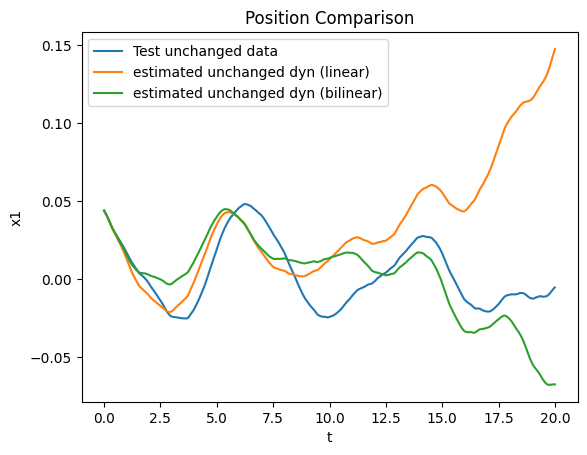

In [38]:
plt.figure()
plt.plot(T_test[:-1], x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test, x_unchanged_lin_est[:,0],label = 'estimated unchanged dyn (linear)')
plt.plot(T_test, x_unchanged_bil_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

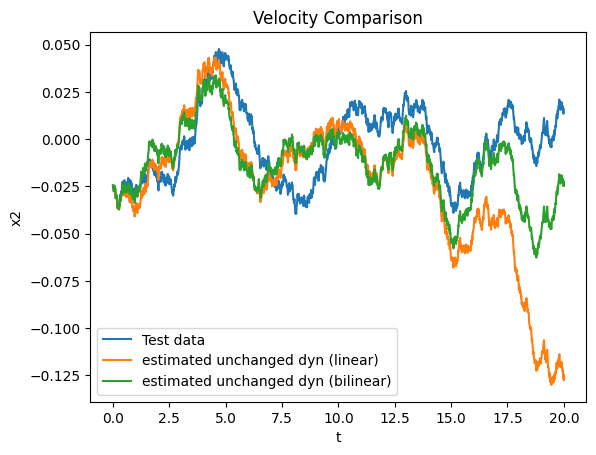

In [39]:
plt.figure()
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data')
plt.plot(T_test, x_unchanged_lin_est[:,1],label = 'estimated unchanged dyn (linear)')
plt.plot(T_test, x_unchanged_bil_est[:,1],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

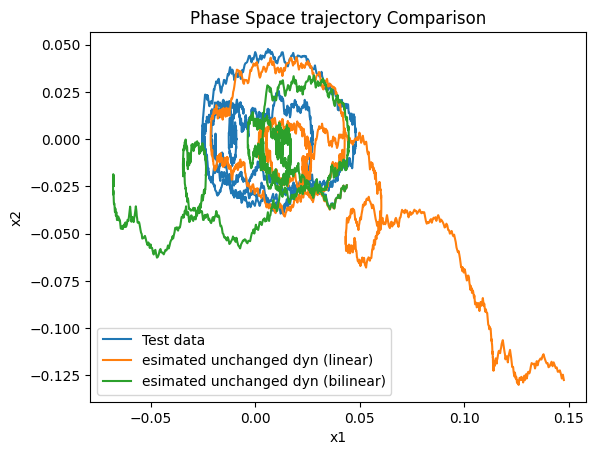

In [40]:
plt.figure()
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data')
plt.plot(x_unchanged_lin_est[:,0],x_unchanged_lin_est[:,1],label = 'esimated unchanged dyn (linear)')
plt.plot(x_unchanged_bil_est[:,0],x_unchanged_bil_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [41]:
error_model_lin = np.linalg.norm((x_unchanged_lin_est[:-1,:]-x_unchanged[:,:]),axis=1)
error_model_bil = np.linalg.norm((x_unchanged_bil_est[:-1,:]-x_unchanged[:,:]),axis=1)

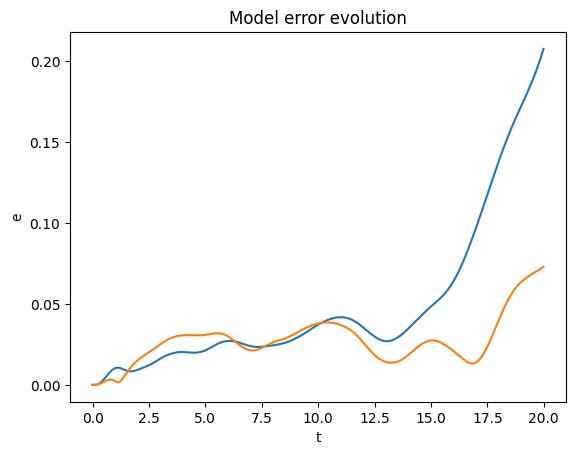

In [42]:
plt.figure()
plt.plot(T_test[:-1],error_model_lin)
plt.plot(T_test[:-1],error_model_bil)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

# Adaptation

## Data Preprocessing

In [43]:
## Linear model
# initialize state matricies
z_adap_lin = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
z_changed_lin = np.empty((n_obs,num_snaps_test)).T #actual lifted state
del_z_prime_lin = np.empty((n_obs,num_snaps_test)).T
x_adap_est_lin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
del_A_norm_lin = np.zeros((num_snaps_test,1))
del_B_norm_lin = np.zeros((num_snaps_test,1))
# initialize
z_adap_lin[0,:] = z_unchanged_lin[0,:]
x_adap_est_lin[0,:] = x_unchanged[0,:]

# bilinear models
# initialize state matricies
z_adap_bil = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
z_changed_bil = np.empty((n_obs,num_snaps_test)).T #actual lifted state

del_z_prime_bil = np.empty((n_obs,num_snaps_test)).T
zu_unchanged = np.empty((n_obs*num_inputs,num_snaps_test)).T
x_adap_est_bil = np.zeros((num_states,num_snaps_test+1)).T #estimated values
del_A_norm_bil = np.zeros((num_snaps_test,1))
del_B_norm_bil = np.zeros((num_snaps_test,1))
# initialize
z_adap_bil[0,:] = z_unchanged_bil[0,:]
x_adap_est_bil[0,:] = x_unchanged[0,:]
zu_unchanged[0,:] = np.kron(u[0,:],z_unchanged_bil[0,:])

#
adap_window = 3 #hyperparameter

In [44]:
adapt_net_params_lin = {}
adapt_net_params_lin['state_dim'] = num_states
adapt_net_params_lin['ctrl_dim'] = num_inputs
adapt_net_params_lin['lift_dim'] = 20
adapt_net_params_lin['optimizer'] = 'adam'
adapt_net_params_lin['lr'] = 2e-4 # 5e-4
adapt_net_params_lin['epochs'] = 5
adapt_net_params_lin['batch_size'] = adap_window
adapt_net_params_lin['l2_reg'] = 1e-2
adapt_net_params_lin['l1_reg'] = 0
adapt_net_params_lin['first_obs_const'] = net_params_lin["first_obs_const"]
adapt_net_params_lin['override_C'] = net_params_lin["override_C"] # this makes the state a part of lifted state
adapt_net_params_lin['warm_start'] = False

adapt_net_params_bil = {}
adapt_net_params_bil['state_dim'] = num_states
adapt_net_params_bil['ctrl_dim'] = num_inputs
adapt_net_params_bil['lift_dim'] = 20
adapt_net_params_bil['optimizer'] = 'adam'
adapt_net_params_bil['lr'] = 2e-4 # 5e-4
adapt_net_params_bil['epochs'] = 5
adapt_net_params_bil['batch_size'] = adap_window
adapt_net_params_bil['l2_reg'] = 1e-2
adapt_net_params_bil['l1_reg'] = 0
adapt_net_params_bil['first_obs_const'] = net_params_bil["first_obs_const"]
adapt_net_params_bil['override_C'] = net_params_bil["override_C"] # this makes the state a part of lifted state
adapt_net_params_bil['warm_start'] = False

del_A_lin = np.zeros_like(A_lin)
del_B_lin = np.zeros_like(B_lin)

del_A_bil = np.zeros_like(A_bil)
del_B_bil = np.zeros_like(B_bil)

adapt_net_params_lin['del_A_prev'] = del_A_lin
adapt_net_params_lin['del_B_prev'] = del_B_lin

adapt_net_params_bil['del_A_prev'] = del_A_bil
adapt_net_params_bil['del_B_prev'] = del_B_bil

switch_time = 50
ctrb_lin = []
ctrb_bil = []

for i in range(num_snaps_test):
  # incorrect dynamics
    # z_unchanged[i+1,:] = np.matmul(z_adap[i,:],A.T + del_A.T)+np.matmul(zu_unchanged[i,:],B.T + del_B.T)
    z_unchanged_lin[i+1,:] = np.matmul(z_adap_lin[i,:],A_lin.T)+np.matmul(u[i,:],B_lin.T)
    z_unchanged_bil[i+1,:] = np.matmul(z_adap_bil[i,:],A_bil.T)+np.matmul(zu_unchanged[i,:],B_bil.T)
    
    
    z_changed_lin[i,:] = lift(x_changed[i,:],model_koop_dnn_lin, net_params_lin)
    z_changed_bil[i,:] = lift(x_changed[i,:],model_koop_dnn_bil, net_params_bil)
    
    del_z_prime_lin[i,:] = z_changed_lin[i,:] - z_unchanged_lin[i,:]
    del_z_prime_bil[i,:] = z_changed_bil[i,:] - z_unchanged_bil[i,:]
    
    if T_test[i] < switch_time:
        if i < adap_window + 1 :
            del_A_lin = np.zeros_like(A_lin)
            del_B_lin = np.zeros_like(B_lin)
            
            del_A_bil = np.zeros_like(A_bil)
            del_B_bil = np.zeros_like(B_bil)
        else:
            del_Z_prime_lin = del_z_prime_lin[i-adap_window:i,:].T
            Z_unchanged_lin = z_unchanged_lin[i-(adap_window+1):i-1].T
            
            del_Z_prime_bil = del_z_prime_bil[i-adap_window:i,:].T
            Z_unchanged_bil = z_unchanged_bil[i-(adap_window+1):i-1].T
            ZU_unchanged = zu_unchanged[i-(adap_window+1):i-1].T
            
            
            U = u[i-(adap_window+1):i-1].T

            #invoke neural net for adapation
            adapt_network_lin = AdaptNet_lin(adapt_net_params_lin)
            adapt_network_lin.model_pipeline(Z_unchanged_lin, U, del_Z_prime_lin, print_epoch = True)
            

            del_A_lin, del_B_lin = adapt_network_lin.get_del_matrices()
            
            #invoke neural net for adapation
            adapt_network_bil = AdaptNet(adapt_net_params_bil)
            adapt_network_bil.model_pipeline(Z_unchanged_bil, ZU_unchanged, del_Z_prime_bil, print_epoch = True)

            del_A_bil, del_B_bil = adapt_network_bil.get_del_matrices()
            
            
            

    del_A_norm_bil[i] = np.linalg.norm(del_A_lin)
    del_B_norm_bil[i] = np.linalg.norm(del_B_lin)
    
    del_A_norm_bil[i] = np.linalg.norm(del_A_bil)
    del_B_norm_bil[i] = np.linalg.norm(del_B_bil)
    
    # if del_B_norm[i] < np.linalg.norm(B):
    #     B_factor = adap_factor
    # else:
    #     B_factor = adap_factor*np.linalg.norm(B)/del_B_norm[i]
    #
    # if del_A_norm[i] < np.linalg.norm(A):
    #     A_factor = adap_factor
    # else:
    #     A_factor = adap_factor*np.linalg.norm(A)/del_A_norm[i]
    #
    # del_A = A_factor*del_A
    # del_B = B_factor*del_B
    adapt_net_params_lin['del_A_prev'] = del_A_lin
    adapt_net_params_lin['del_B_prev'] = del_B_lin
    
    adapt_net_params_bil['del_A_prev'] = del_A_bil
    adapt_net_params_bil['del_B_prev'] = del_B_bil
    
    # adapted model
    z_adap_lin[i+1,:] = np.matmul(z_adap_lin[i,:], A_lin.T+del_A_lin.T) + np.matmul(u[i,:], B_lin.T + del_B_lin.T )
    x_adap_est_lin[i+1,:] = np.matmul(z_adap_lin[i+1,:],C_lin.T)
    
    # adapted model
    z_adap_bil[i+1,:] = np.matmul(z_adap_bil[i,:], A_bil.T+del_A_bil.T) + np.matmul(np.kron(u[i,:],z_adap_bil[i,:]), B_bil.T + del_B_bil.T )
    x_adap_est_bil[i+1,:] = np.matmul(z_adap_bil[i+1,:],C_bil.T)
    
    Con_lin = ct.ctrb(A_lin + del_A_lin, B_lin + del_B_lin)
    rank_lin = np.linalg.matrix_rank(Con_lin)
    ctrb_lin.append(rank_lin)

    # Con_bil = ct.ctrb(A_bil + del_A_bil, B_bil + del_B_bil)
    # rank_bil = np.linalg.matrix_rank(Con_bil)
    # ctrb_bil.append(rank_bil)

/tmp/ipykernel_6700/498797300.py:49: RuntimeWarning: invalid value encountered in matmul
  z_unchanged_bil[i+1,:] = np.matmul(z_adap_bil[i,:],A_bil.T)+np.matmul(zu_unchanged[i,:],B_bil.T)


Text(0, 0.5, 'Rank linear Kyrlov Matrix')

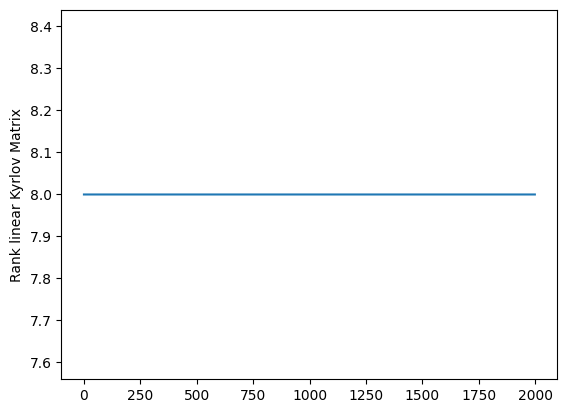

In [45]:
plt.figure()
plt.plot(ctrb_lin)
plt.ylabel('Rank linear Kyrlov Matrix')